### RANDOM FOREST REGRESSOR  Y KERAS SOLO CON ESTRUCTURAS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### DATA LOADING

In [2]:
#TRAIN:
df1=pd.read_csv("/Users/rociocuestapedraz/Desktop/champs-scalar-coupling/train.csv")
#TEST:
df2=pd.read_csv("/Users/rociocuestapedraz/Desktop/champs-scalar-coupling/test.csv")
#COORDENADAS
df3=pd.read_csv("/Users/rociocuestapedraz/Desktop/champs-scalar-coupling/structures.csv")

#### UNIR LOS 2 DATAFRAMES PRINCIPALES

In [3]:
#merge con coordenadas en Train
df= df1.rename(columns={"atom_index_0":"atom_index"})
df= pd.merge(left=df, right=df3, on =["atom_index","molecule_name"])
df=df.rename(columns={"atom_index":"atom_index_0"})
df=df.rename(columns={"x":"x_0","y":"y_0","z":"z_0","atom":"atom_0"})

df=df.rename(columns={"atom_index_1":"atom_index"})
df= pd.merge(left=df, right=df3, on =["atom_index","molecule_name"])
df=df.rename(columns={"atom_index":"atom_index_1"})
df=df.rename(columns={"x":"x_1","y":"y_1","z":"z_1","atom":"atom_1"})
df.reset_index(drop=True,inplace=True)

#### BUSQUEDA DE VARIABLES

Ya que solo disponemos de las coordenadas atómicas, en esta primera fase incorporo diferentes variables basados en las distancias y estructura molecular:
- Calculo de distancia Euclideana, Manhattan y Chevisev.
- Calculo de numero de atómos por molecula.
- Punto centro de la molecula.
- Distancia minima, maxima y media en la molecula (Para Euclideana, Manhattan y Chevisev)

In [4]:
def distance(v1, v2):
       return np.sqrt(np.sum((v1 - v2) ** 2))

def manhattan(v1,v2):
    return sum(abs(v1-v2))

def chevisev(v1,v2):
    return(max(abs(v1-v2)))

In [5]:
#Distances
distancia_euclidiana=[]
for i in range(len(df)):
    A=np.array([df["x_0"][i],df["y_0"][i],df["z_0"][i]])
    B=np.array([df["x_1"][i],df["y_1"][i],df["z_1"][i]])
    dist=distance(A,B)
    distancia_euclidiana.append(dist)


distancia_manhattan=[]
for i in range(len(df)):
    A=np.array([df["x_0"][i],df["y_0"][i],df["z_0"][i]])
    B=np.array([df["x_1"][i],df["y_1"][i],df["z_1"][i]])
    dist=manhattan(A,B)
    distancia_manhattan.append(dist)


distancia_chevisev=[]
for i in range(len(df)):
    A=np.array([df["x_0"][i],df["y_0"][i],df["z_0"][i]])
    B=np.array([df["x_1"][i],df["y_1"][i],df["z_1"][i]])
    dist=chevisev(A,B)
    distancia_chevisev.append(dist)

In [6]:
df["Distancia Euclideana"]=distancia_euclidiana
df["Distancia Manhattan"]=distancia_manhattan
df["Distancia Chevisev"]=distancia_chevisev

In [7]:
#Enlaces por moleculas
enlaces=df.groupby(["molecule_name"]).count()["id"].tolist()

In [8]:
df_mol=pd.DataFrame()
df_mol["molecule_name"]=df["molecule_name"].unique()
df_mol["Num enlaces"]=enlaces

In [9]:
# Atoms in molecule
max_atom0=df.groupby(["molecule_name"])["atom_index_0"].max()
max_atom1=df.groupby(["molecule_name"])["atom_index_1"].max()
atomos_mol=[]
for i,j in zip(max_atom0,max_atom0):
    if i>j:
        atomos_mol.append(i+1)
    else:
        atomos_mol.append(j+1)

In [10]:
df_mol["Num atomos"]=atomos_mol

In [11]:
#Min, max and mean of distances
df_mol["Mean Euclidea"]=df.groupby(["molecule_name"])["Distancia Euclideana"].mean().tolist()
df_mol["Min Euclidea"]=df.groupby(["molecule_name"])["Distancia Euclideana"].min().tolist()
df_mol["Max Euclidea"]=df.groupby(["molecule_name"])["Distancia Euclideana"].max().tolist()

df_mol["Mean Manhattan"]=df.groupby(["molecule_name"])["Distancia Manhattan"].mean().tolist()
df_mol["Min Manhattan"]=df.groupby(["molecule_name"])["Distancia Manhattan"].min().tolist()
df_mol["Max Manhattan"]=df.groupby(["molecule_name"])["Distancia Manhattan"].max().tolist()


df_mol["Mean Chevisev"]=df.groupby(["molecule_name"])["Distancia Chevisev"].mean().tolist()
df_mol["Min Chevisev"]=df.groupby(["molecule_name"])["Distancia Chevisev"].min().tolist()
df_mol["Max Chevisev"]=df.groupby(["molecule_name"])["Distancia Chevisev"].max().tolist()


In [12]:
df3= pd.merge(left=df, right=df_mol, on =["molecule_name"])

#### DIVISION DE DATOS CATEGORICOS Y NUMERICOS Y NORMALIZACION

In [13]:
df3_cat=df3[["atom_0","atom_1"]]
from sklearn.preprocessing import LabelEncoder
le= LabelEncoder()
df3_cat2=df3_cat.apply(le.fit_transform)

In [14]:
df3_cat2=df3_cat2.rename(columns={'atom_0':"atom_0_le", "atom_1":"atom_1_le"})

In [15]:
df3=pd.concat([df3,df3_cat2],axis=1)

In [16]:
del df3["atom_0"]
del df3["atom_1"]

In [17]:
df3_num=df3[['atom_index_0', 'atom_index_1', 'x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1',
       'Distancia Euclideana', 'Distancia Manhattan', 'Distancia Chevisev',
       'Num enlaces', 'Num atomos', 'Mean Euclidea', 'Min Euclidea',
       'Max Euclidea', 'Mean Manhattan', 'Min Manhattan', 'Max Manhattan',
       'Mean Chevisev', 'Min Chevisev', 'Max Chevisev', 'atom_0_le',
       'atom_1_le']]
df3_cat=df3['type']
df3_clave=df3['scalar_coupling_constant']

In [18]:
#Normalizo los df_num
from sklearn.preprocessing import MinMaxScaler
df_num2 = MinMaxScaler().fit_transform(df3_num)
df_num2 = pd.DataFrame(df_num2, columns = df3_num.columns)

In [19]:
df4=pd.concat([df3_cat,df_num2,df3_clave],axis=1)

In [20]:
df4.head()

,type,atom_index_0,atom_index_1,x_0,y_0,z_0,x_1,y_1,z_1,Distancia Euclideana,...,Max Euclidea,Mean Manhattan,Min Manhattan,Max Manhattan,Mean Chevisev,Min Chevisev,Max Chevisev,atom_0_le,atom_1_le,scalar_coupling_constant
0,1JHC,0.000000,0.000000,0.496158,0.493535,0.537845,0.522333,0.553449,0.526374,0.030797,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.0,84.8076
1,1JHC,0.037037,0.000000,0.550387,0.566601,0.537742,0.522333,0.553449,0.526374,0.030796,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.0,84.8074
2,1JHC,0.074074,0.000000,0.466993,0.565795,0.484816,0.522333,0.553449,0.526374,0.030795,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.0,84.8093
3,1JHC,0.111111,0.000000,0.467906,0.565318,0.592431,0.522333,0.553449,0.526374,0.030795,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.0,84.8095
4,2JHH,0.000000,0.071429,0.496158,0.493535,0.537845,0.580355,0.574455,0.525895,0.268064,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.5,-11.2570


In [21]:
X=np.asanyarray(df4[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df4["scalar_coupling_constant"])

In [22]:
df4.to_csv("c.scalar3_df4_.csv")

In [7]:
df4=pd.read_csv("/Users/rociocuestapedraz/Desktop/champs-scalar-coupling/c.scalar3_df4_.csv")

In [8]:
df4.head()

,Unnamed: 0,type,atom_index_0,atom_index_1,x_0,y_0,z_0,x_1,y_1,z_1,...,Max Euclidea,Mean Manhattan,Min Manhattan,Max Manhattan,Mean Chevisev,Min Chevisev,Max Chevisev,atom_0_le,atom_1_le,scalar_coupling_constant
0,0,1JHC,0.000000,0.000000,0.496158,0.493535,0.537845,0.522333,0.553449,0.526374,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.0,84.8076
1,1,1JHC,0.037037,0.000000,0.550387,0.566601,0.537742,0.522333,0.553449,0.526374,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.0,84.8074
2,2,1JHC,0.074074,0.000000,0.466993,0.565795,0.484816,0.522333,0.553449,0.526374,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.0,84.8093
3,3,1JHC,0.111111,0.000000,0.467906,0.565318,0.592431,0.522333,0.553449,0.526374,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.0,84.8095
4,4,2JHH,0.000000,0.071429,0.496158,0.493535,0.537845,0.580355,0.574455,0.525895,...,0.239706,0.220055,0.062417,0.258197,0.265923,0.254388,0.288013,0.0,0.5,-11.2570


#### CREACION DE FUNCIONES NECESARIAS PARA LAS REGRESIONES

In [9]:
#Importar librerias para Regresion
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
#Importar librerias para red neuronal
import tensorflow as tf
from tensorflow import keras

In [10]:
#Regresion Hold Out con random forest
def Random_forest_Regressor(X_train,y_train,X_test,y_test):
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.datasets import make_regression
    regr = RandomForestRegressor(n_estimators = 100, random_state = 0,n_jobs=-1)
    regr.fit(X_train, y_train)
    yhat = regr.predict(X_test)
    return yhat, r2_score(y_test,yhat),mean_squared_error(yhat,y_test)

In [11]:
def kfold_split_Random(X,y):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=5)
    R2=[]
    MSE=[]
    yhat=[]
    y_test=[]
    for train_index, test_index in kf.split(X):
    
        Xtrain, Xtest = X[train_index], X[test_index]
        ytrain, ytest = y[train_index], y[test_index]
        regr = RandomForestRegressor(n_estimators = 100, random_state = 0,n_jobs=-1)
        regr.fit(Xtrain, ytrain)
        yhat2 = regr.predict(Xtest)
        yhat.extend(yhat2)
        y_test.extend(ytest)
        r2=r2_score(ytest,yhat2)
        mse=mean_squared_error(yhat2,ytest)
        R2.append(r2)
        MSE.append(mse)
        return(yhat,y_test,r2,mse)

In [12]:
def red_neuronal_regress(X,y):
    #HOLD OUT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
    #Construyo el modelo
    model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=[X_train.shape[0],X_train.shape[1]]),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1) #el 10 es necesario porque son 10 clases 
    ])
    # Elegimos hiperparametros 
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(optimizer=optimizer,loss='mse',metrics=['mae', 'mse'])
    history=model.fit(X_train, y_train, epochs=50, verbose=1)
    loss, mae, mse = model.evaluate(X_test, y_test, verbose=2)
    print("loss= ",loss)
    print("mae= ",mae)
    print("mse= ",mse)
    predictions = model.predict(X_test)
    plt.plot(history.history["mse"])
    plt.show()
    plt.plot(history.history["mae"])
    plt.show()
    predictions =model.predict(X_test)
    print("Porcentaje de acierto con Keras:")
    acierto_red(predictions,y_test)
    return model

In [16]:
#Acierto para Random forset
def acierto_random(yhat,y_test):
    lista=[5,1,0.5]
    for j in lista:
        counter=0
        for i in range(len(y_test)):
            if yhat[i]-j<y_test[i]<yhat[i]+j:
                counter+=1
        acierto=(counter/len(y_test)*100)
        print("ACIERTO CON +/-",j,": ",acierto,"%")

In [17]:
#Acierto para Red con Keras
def acierto_red(predictions,y_test):
    yhat2=predictions.tolist()
    ytest2=y_test.tolist()
    lista=[5,1,0.5]
    for j in lista:
        counter=0
        for i in range(len(y_test)):
            if yhat2[i][0]-j<ytest2[i]<yhat2[i][0]+j:
                counter+=1
        acierto=(counter/len(ytest2)*100)
        print("ACIERTO CON +/-",j,": ",acierto,"%")

In [15]:
#Feature Importance
def feature_importance(X,y):
    from sklearn.tree import DecisionTreeRegressor
    # Build a forest and compute the feature importances
    forest = DecisionTreeRegressor()
    forest.fit(X, y)
    importances = forest.feature_importances_

    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(X.shape[1]):
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices],color="r", align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

### Aplicare de nuevo, Random Forest Regressor y red neuronal Keras, y como metodo de validacion k-Fold validation stratified con 5 folds ,las metricas empleadas en Keras seran MAE y MSE y R2-score y MSE para el ánalisis con Random forest Regression.
Los rangos para evaluar el acierto, en este caso seran +/- 5, +/- 1 y +/- 0.5.

### 1JHC:

In [18]:
df_a=df4[df4["type"]=="1JHC"]
df_a.reset_index(drop=True,inplace=True)
X=np.asanyarray(df_a[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df_a["scalar_coupling_constant"])

In [19]:
RFR=kfold_split_Random(X,y)

In [20]:
yhat=RFR[0]
ytest=RFR[1]
R2_squared=RFR[2]
mse=RFR[3]

In [21]:
print("R2_squared: ",R2_squared)
print("mse: ",mse)
acierto_random(yhat,ytest)

R2_squared:  0.9184686294721238
mse:  33.830123282558105
ACIERTO CON +/- 5 :  74.12974962454257 %
ACIERTO CON +/- 1 :  23.15497049221939 %
ACIERTO CON +/- 0.5 :  12.166935773865344 %


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
15513/15513 [==============================] - 25s 2ms/step - loss: 248.8884 - mae: 10.5865 - mse: 248.8884
Epoch 2/50
15513/15513 [==============================] - 26s 2ms/step - loss: 153.9643 - mae: 8.9209 - mse: 153.9643
Epoch 3/50
15513/15513 [==============================] - 27s 2ms/step - loss: 109.1998 - mae: 7.6311 - mse: 109.1998
Epoch 4/50
15513/15513 [=========

6649/6649 - 7s - loss: 39.2115 - mae: 4.4533 - mse: 39.2115
loss=  39.211524963378906
mae=  4.45328426361084
mse=  39.211524963378906
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


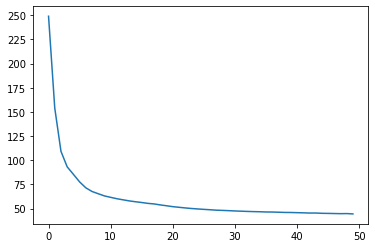

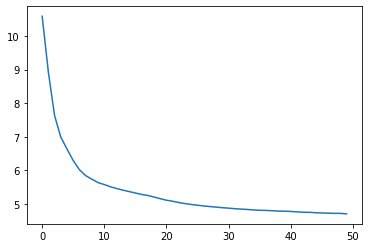

Porcentaje de acierto con Keras:
ACIERTO CON +/- 5 :  67.56228259847703 %
ACIERTO CON +/- 1 :  17.75876656952148 %
ACIERTO CON +/- 0.5 :  8.913697471091474 %


In [22]:
red_neuronal_regress(X,y)

### 2JHH

In [23]:
df_b=df4[df4["type"]=='2JHH']
del df_b["type"]
df_b.reset_index(drop=True,inplace=True)
X=np.asanyarray(df_b[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df_b["scalar_coupling_constant"])

In [24]:
RFR=kfold_split_Random(X,y)

In [25]:
yhat=RFR[0]
ytest=RFR[1]
R2_squared=RFR[2]
mse=RFR[3]

In [26]:
print("R2_squared: ",R2_squared)
print("mse: ",mse)
acierto_random(yhat,ytest)

R2_squared:  0.8556884433141683
mse:  2.481022027265233
ACIERTO CON +/- 5 :  98.77509987036694 %
ACIERTO CON +/- 1 :  72.02174660705309 %
ACIERTO CON +/- 0.5 :  50.185190084393774 %


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8269/8269 [==============================] - 16s 2ms/step - loss: 14.6106 - mae: 2.5528 - mse: 14.6106
Epoch 2/50
8269/8269 [==============================] - 15s 2ms/step - loss: 11.8832 - mae: 2.2645 - mse: 11.8832
Epoch 3/50
8269/8269 [==============================] - 13s 2ms/step - loss: 9.8208 - mae: 2.0435 - mse: 9.8208
Epoch 4/50
8269/8269 [==========================

loss=  8.251642227172852
mae=  2.326162815093994
mse=  8.251642227172852
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


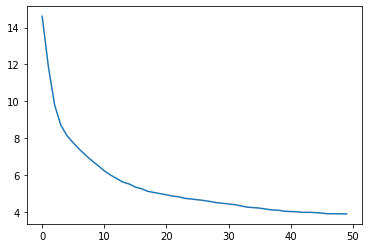

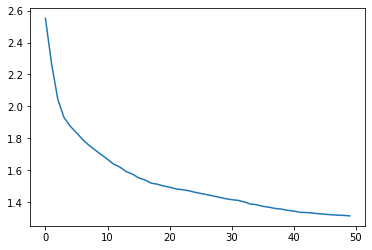

Porcentaje de acierto con Keras:
ACIERTO CON +/- 5 :  92.90986534035291 %
ACIERTO CON +/- 1 :  17.46342495833223 %
ACIERTO CON +/- 0.5 :  6.104217924636454 %


In [27]:
red_neuronal_regress(X,y)

### 1JHN

In [28]:
df_c=df4[df4["type"]=='1JHN']
del df_c["type"]
df_c.reset_index(drop=True,inplace=True)

X=np.asanyarray(df_c[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df_c["scalar_coupling_constant"])

In [29]:
RFR=kfold_split_Random(X,y)

In [30]:
yhat=RFR[0]
ytest=RFR[1]
R2_squared=RFR[2]
mse=RFR[3]
print("R2_squared: ",R2_squared)
print("mse: ",mse)
acierto_random(yhat,ytest)

R2_squared:  0.829927816889511
mse:  20.359095781731295
ACIERTO CON +/- 5 :  84.66117216117216 %
ACIERTO CON +/- 1 :  31.238553113553113 %
ACIERTO CON +/- 0.5 :  16.575091575091573 %


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
956/956 [==============================] - 1s 1ms/step - loss: 200.1494 - mae: 11.2296 - mse: 200.1494
Epoch 2/50
956/956 [==============================] - 1s 2ms/step - loss: 96.5462 - mae: 8.4349 - mse: 96.5462
Epoch 3/50
956/956 [==============================] - 1s 2ms/step - loss: 73.4876 - mae: 7.1756 - mse: 73.4876
Epoch 4/50
956/956 [==============================] 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


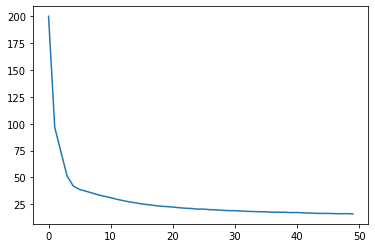

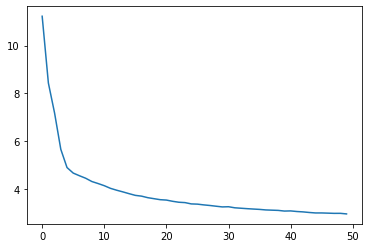

Porcentaje de acierto con Keras:
ACIERTO CON +/- 5 :  86.82844932844932 %
ACIERTO CON +/- 1 :  26.41941391941392 %
ACIERTO CON +/- 0.5 :  13.27838827838828 %


In [31]:
red_neuronal_regress(X,y)

### 2JHN

In [32]:
df_d=df4[df4["type"]=='2JHN']
del df_d["type"]
df_d.reset_index(drop=True,inplace=True)

X=np.asanyarray(df_d[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df_d["scalar_coupling_constant"])

In [33]:
RFR=kfold_split_Random(X,y)

In [34]:
yhat=RFR[0]
ytest=RFR[1]
R2_squared=RFR[2]
mse=RFR[3]
print("R2_squared: ",R2_squared)
print("mse: ",mse)
acierto_random(yhat,ytest)

R2_squared:  0.5144098626705162
mse:  7.502578745009997
ACIERTO CON +/- 5 :  94.02402150176383 %
ACIERTO CON +/- 1 :  54.06097765832354 %
ACIERTO CON +/- 0.5 :  36.79657315639174 %


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2605/2605 [==============================] - 4s 2ms/step - loss: 10.5965 - mae: 2.5286 - mse: 10.5965
Epoch 2/50
2605/2605 [==============================] - 4s 1ms/step - loss: 9.6407 - mae: 2.3860 - mse: 9.6407
Epoch 3/50
2605/2605 [==============================] - 4s 2ms/step - loss: 9.3645 - mae: 2.3479 - mse: 9.3645
Epoch 4/50
2605/2605 [==============================]

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


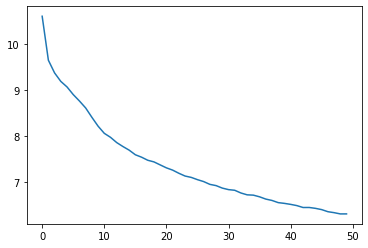

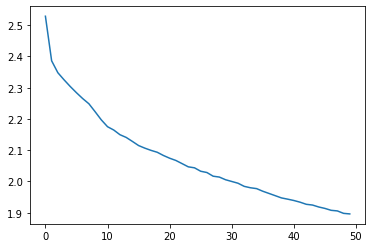

Porcentaje de acierto con Keras:
ACIERTO CON +/- 5 :  94.04221960916065 %
ACIERTO CON +/- 1 :  35.51430651212274 %
ACIERTO CON +/- 0.5 :  18.172910017358195 %


In [35]:
red_neuronal_regress(X,y)

### 2JHC

In [36]:
df_e=df4[df4["type"]=='2JHC']
del df_e["type"]
df_e.reset_index(drop=True,inplace=True)

X=np.asanyarray(df_e[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df_e["scalar_coupling_constant"])

In [37]:
RFR=kfold_split_Random(X,y)

In [38]:
yhat=RFR[0]
ytest=RFR[1]
R2_squared=RFR[2]
mse=RFR[3]
print("R2_squared: ",R2_squared)
print("mse: ",mse)
acierto_random(yhat,ytest)

R2_squared:  0.5336574031650159
mse:  11.099212798112838
ACIERTO CON +/- 5 :  92.49125667253938 %
ACIERTO CON +/- 1 :  43.09562000929115 %
ACIERTO CON +/- 0.5 :  25.494578698712385 %


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24957/24957 [==============================] - 40s 2ms/step - loss: 17.8773 - mae: 2.5713 - mse: 17.8773
Epoch 2/50
24957/24957 [==============================] - 39s 2ms/step - loss: 16.4649 - mae: 2.5071 - mse: 16.4649
Epoch 3/50
24957/24957 [==============================] - 39s 2ms/step - loss: 15.6150 - mae: 2.4634 - mse: 15.6150
Epoch 4/50
24957/24957 [================

10696/10696 - 13s - loss: 12.4343 - mae: 2.2114 - mse: 12.4343
loss=  12.434341430664062
mae=  2.2113914489746094
mse=  12.434341430664062
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


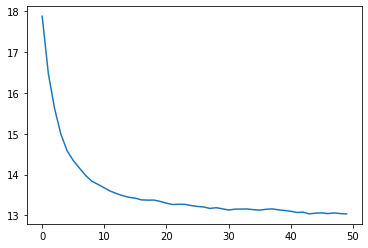

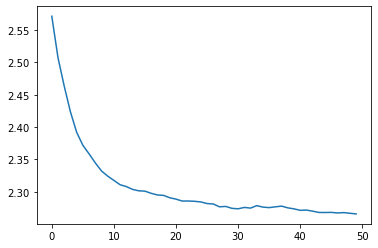

Porcentaje de acierto con Keras:
ACIERTO CON +/- 5 :  92.20039677322276 %
ACIERTO CON +/- 1 :  34.662728151907466 %
ACIERTO CON +/- 0.5 :  18.208910743555357 %


In [39]:
red_neuronal_regress(X,y)

### 3JHH

In [40]:
df_f=df4[df4["type"]=='3JHH']
del df_f["type"]
df_f.reset_index(drop=True,inplace=True)

X=np.asanyarray(df_f[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df_f["scalar_coupling_constant"])

In [41]:
RFR=kfold_split_Random(X,y)

In [42]:
yhat=RFR[0]
ytest=RFR[1]
R2_squared=RFR[2]
mse=RFR[3]
print("R2_squared: ",R2_squared)
print("mse: ",mse)
acierto_random(yhat,ytest)

R2_squared:  0.7192303344897617
mse:  3.9821517645123565
ACIERTO CON +/- 5 :  96.98491185883867 %
ACIERTO CON +/- 1 :  54.27412663200853 %
ACIERTO CON +/- 0.5 :  33.8975157908997 %


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
12918/12918 [==============================] - 24s 2ms/step - loss: 8.6967 - mae: 2.2663 - mse: 8.6967
Epoch 2/50
12918/12918 [==============================] - 22s 2ms/step - loss: 7.2556 - mae: 1.9948 - mse: 7.2556: 0s - loss: 7.2600 - mae: 1.9956 - m
Epoch 3/50
12918/12918 [==============================] - 22s 2ms/step - loss: 6.7821 - mae: 1.9075 - mse: 6.7821
Epoch 4/5

5537/5537 - 7s - loss: 3.9344 - mae: 1.4488 - mse: 3.9344
loss=  3.934436798095703
mae=  1.4487757682800293
mse=  3.934436798095703
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


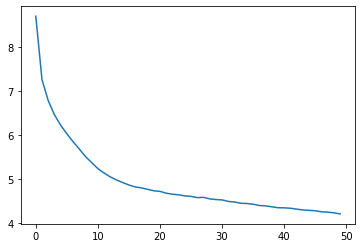

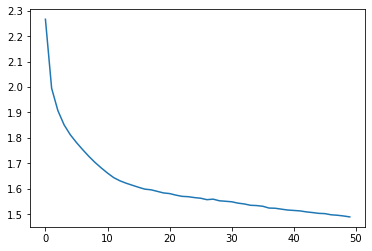

Porcentaje de acierto con Keras:
ACIERTO CON +/- 5 :  97.50450160590204 %
ACIERTO CON +/- 1 :  47.074661744534566 %
ACIERTO CON +/- 0.5 :  26.257768445294904 %


In [43]:
red_neuronal_regress(X,y)

### 3JHC

In [44]:
df_g=df4[df4["type"]=='3JHC']
del df_g["type"]
df_g.reset_index(drop=True,inplace=True)

X=np.asanyarray(df_g[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df_g["scalar_coupling_constant"])

In [45]:
RFR=kfold_split_Random(X,y)

In [46]:
yhat=RFR[0]
ytest=RFR[1]
R2_squared=RFR[2]
mse=RFR[3]
print("R2_squared: ",R2_squared)
print("mse: ",mse)
acierto_random(yhat,ytest)

R2_squared:  0.5650513951224909
mse:  4.191900356244448
ACIERTO CON +/- 5 :  97.28628053017118 %
ACIERTO CON +/- 1 :  52.0721805705362 %
ACIERTO CON +/- 0.5 :  31.553523335605245 %


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
33058/33058 [==============================] - 50s 2ms/step - loss: 7.1700 - mae: 2.0156 - mse: 7.1700
Epoch 2/50
33058/33058 [==============================] - 50s 2ms/step - loss: 6.7179 - mae: 1.9317 - mse: 6.7179
Epoch 3/50
33058/33058 [==============================] - 50s 2ms/step - loss: 6.6117 - mae: 1.9125 - mse: 6.6117
Epoch 4/50
33058/33058 [======================

14168/14168 - 15s - loss: 6.0938 - mae: 1.8108 - mse: 6.0938
loss=  6.093836307525635
mae=  1.8108419179916382
mse=  6.093836307525635
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


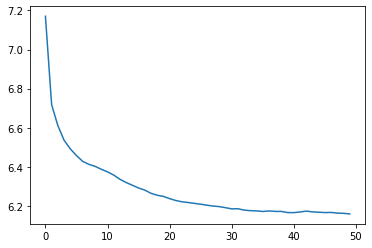

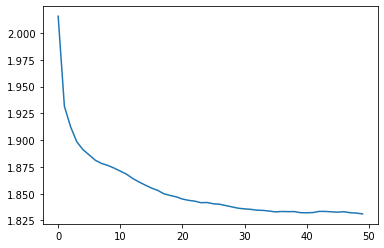

Porcentaje de acierto con Keras:
ACIERTO CON +/- 5 :  95.7934370471344 %
ACIERTO CON +/- 1 :  38.501156909584594 %
ACIERTO CON +/- 0.5 :  20.61813601903993 %


In [47]:
red_neuronal_regress(X,y)

### 3JHN

In [48]:
df_h=df4[df4["type"]=='3JHN']
del df_h["type"]
df_h.reset_index(drop=True,inplace=True)

X=np.asanyarray(df_h[['atom_index_0', 'atom_index_1','x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1', 'Distancia Euclideana',
       'Distancia Manhattan', 'Distancia Chevisev', 'Num enlaces',
       'Num atomos', 'Mean Euclidea', 'Min Euclidea', 'Max Euclidea',
       'Mean Manhattan', 'Min Manhattan', 'Max Manhattan', 'Mean Chevisev',
       'Min Chevisev', 'Max Chevisev', 'atom_0_le', 'atom_1_le']])
y=np.asanyarray(df_h["scalar_coupling_constant"])

In [49]:
RFR=kfold_split_Random(X,y)

In [50]:
yhat=RFR[0]
ytest=RFR[1]
R2_squared=RFR[2]
mse=RFR[3]
print("R2_squared: ",R2_squared)
print("mse: ",mse)
acierto_random(yhat,ytest)

R2_squared:  0.5936347351201781
mse:  0.7129787753085078
ACIERTO CON +/- 5 :  99.92197581250187 %
ACIERTO CON +/- 1 :  83.0387420100231 %
ACIERTO CON +/- 0.5 :  61.74714161390031 %


Epoch 1/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
3645/3645 [==============================] - 5s 1ms/step - loss: 1.5356 - mae: 0.8888 - mse: 1.5356
Epoch 2/50
3645/3645 [==============================] - 5s 2ms/step - loss: 1.4466 - mae: 0.8467 - mse: 1.4466
Epoch 3/50
3645/3645 [==============================] - 5s 2ms/step - loss: 1.4047 - mae: 0.8287 - mse: 1.4047
Epoch 4/50
3645/3645 [==============================] -

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


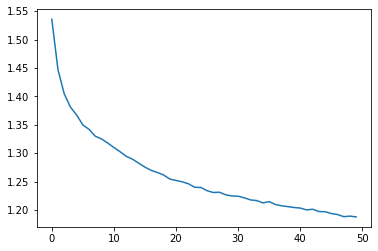

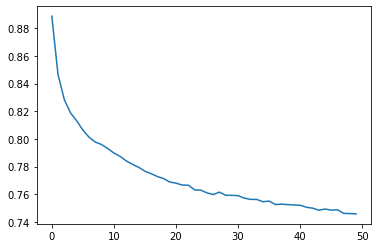

Porcentaje de acierto con Keras:
ACIERTO CON +/- 5 :  99.51384443021767 %
ACIERTO CON +/- 1 :  75.09002880921895 %
ACIERTO CON +/- 0.5 :  50.57218309859155 %


In [51]:
red_neuronal_regress(X,y)

In [57]:
df_size=pd.DataFrame()
df_size["ENLACE"]=['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN']
df_size["SIZE"]=[df_a.shape[0],df_b.shape[0],df_c.shape[0],df_d.shape[0],df_e.shape[0],df_f.shape[0],df_g.shape[0],df_h.shape[0]]

In [53]:
RES=pd.DataFrame()
RES["ENLACE"]=['1JHC','1JHC','1JHC','2JHH','2JHH','2JHH','1JHN','1JHN','1JHN','2JHN','2JHN','2JHN','2JHC','2JHC','2JHC','3JHH','3JHH','3JHH','3JHC','3JHC','3JHC','3JHN','3JHN','3JHN']
RES["PRECISION"]=['%SUCCESS RANGE +/- 5',"%SUCCESS RANGE +/- 1","%SUCCESS RANGE +/-0.5",'%SUCCESS RANGE +/- 5',"%SUCCESS RANGE +/- 1","%SUCCESS RANGE +/-0.5",'%SUCCESS RANGE +/- 5',"%SUCCESS RANGE +/- 1","%SUCCESS RANGE +/-0.5",'%SUCCESS RANGE +/- 5',"%SUCCESS RANGE +/- 1","%SUCCESS RANGE +/-0.5",'%SUCCESS RANGE +/- 5',"%SUCCESS RANGE +/- 1","%SUCCESS RANGE +/-0.5",'%SUCCESS RANGE +/- 5',"%SUCCESS RANGE +/- 1","%SUCCESS RANGE +/-0.5",'%SUCCESS RANGE +/- 5',"%SUCCESS RANGE +/- 1","%SUCCESS RANGE +/-0.5",'%SUCCESS RANGE +/- 5',"%SUCCESS RANGE +/- 1","%SUCCESS RANGE +/-0.5"]
RES["RANDOM FOREST REGRESSOR"]=[74.13,23.15,12.16,98.77,72.02,50.18,84.66,31.23,16.57,94.02,54.06,38.79,92.49,43.09,25.49,96.98,54.27,33.89,97.28,52.07,31.55,99.92,83.04,61.74]
RES["KERAS"]=[67.56,17.75,8.91,92.90,17.46,6.10,86.82,26.41,13.27,94.04,35.51,18.17,92.20,34.66,18.21,97.50,47.07,26.25,95.79,38.50,20.61,99.51,75.09,50.57]
RES

,ENLACE,PRECISION,RANDOM FOREST REGRESSOR,KERAS
0,1JHC,%SUCCESS RANGE +/- 5,74.13,67.56
1,1JHC,%SUCCESS RANGE +/- 1,23.15,17.75
2,1JHC,%SUCCESS RANGE +/-0.5,12.16,8.91
3,2JHH,%SUCCESS RANGE +/- 5,98.77,92.90
4,2JHH,%SUCCESS RANGE +/- 1,72.02,17.46
5,2JHH,%SUCCESS RANGE +/-0.5,50.18,6.10
6,1JHN,%SUCCESS RANGE +/- 5,84.66,86.82
7,1JHN,%SUCCESS RANGE +/- 1,31.23,26.41
8,1JHN,%SUCCESS RANGE +/-0.5,16.57,13.27
9,2JHN,%SUCCESS RANGE +/- 5,94.02,94.04


In [54]:
RES2=pd.DataFrame()
RES2["ENLACE"]=['1JHC','1JHC','2JHH','2JHH','1JHN','1JHN','2JHN','2JHN','2JHC','2JHC','3JHH','3JHH','3JHC','3JHC','3JHN','3JHN']
RES2["METRICAS"]=['R2-SQUARED',"MSE",'R2-SQUARED',"MSE",'R2-SQUARED',"MSE",'R2-SQUARED',"MSE",'R2-SQUARED',"MSE",'R2-SQUARED',"MSE",'R2-SQUARED',"MSE",'R2-SQUARED',"MSE"]
RES2["RANDOM FOREST REGRESSOR"]=[0.9185,33.83,0.8557,2.48,0.8299,20.35,0.5144,7.50,0.5333,11.09,0.7192,3.98,0.5651,4.19,0.5936,0.71]
RES2

,ENLACE,METRICAS,RANDOM FOREST REGRESSOR
0,1JHC,R2-SQUARED,0.9185
1,1JHC,MSE,33.8300
2,2JHH,R2-SQUARED,0.8557
3,2JHH,MSE,2.4800
4,1JHN,R2-SQUARED,0.8299
5,1JHN,MSE,20.3500
6,2JHN,R2-SQUARED,0.5144
7,2JHN,MSE,7.5000
8,2JHC,R2-SQUARED,0.5333
9,2JHC,MSE,11.0900


In [55]:
index = pd.MultiIndex.from_product([['1JHC', '2JHH', '1JHN', '2JHN', '2JHC', '3JHH', '3JHC', '3JHN'], 
                                       ['MAE',"MSE"]], 
                                      names=['COUPLE', 'OUTCOME'])
RES3 = pd.DataFrame(index=index,  columns=["KERAS"])
RES3["KERAS"]=[4.45,39.21,2.32,8.25,2.63,12.52,1.91,6.74,2.21,12.43,1.44,3.93,1.81,6.09,0.74,1.23]
RES3

KERAS
COUPLE OUTCOME       
1JHC   MAE       4.45
       MSE      39.21
2JHH   MAE       2.32
       MSE       8.25
1JHN   MAE       2.63
       MSE      12.52
2JHN   MAE       1.91
       MSE       6.74
2JHC   MAE       2.21
       MSE      12.43
3JHH   MAE       1.44
       MSE       3.93
3JHC   MAE       1.81
       MSE       6.09
3JHN   MAE       0.74
       MSE       1.23

#### CONCLUSIONES:

- La eficiencia de Keras aumenta al tener solo la estructura 3D, pero Random forest sigue siendo mejor.
- Para obtener una precision alta (A partir del 85%) el rango fiable seria +/- 5.
- La precision varia en funcion de los enlaces.

In [58]:
Precision1=RES[RES["PRECISION"]=="%SUCCESS RANGE +/- 5"][["ENLACE","PRECISION","RANDOM FOREST REGRESSOR"]].sort_values(by="RANDOM FOREST REGRESSOR",ascending=False)
Precision1=Precision1[["ENLACE","PRECISION","RANDOM FOREST REGRESSOR"]]
precision1=pd.merge(left=Precision1,right=df_size,on=["ENLACE"])
precision1

,ENLACE,PRECISION,RANDOM FOREST REGRESSOR,SIZE
0,3JHN,%SUCCESS RANGE +/- 5,99.92,166613
1,2JHH,%SUCCESS RANGE +/- 5,98.77,377988
2,3JHC,%SUCCESS RANGE +/- 5,97.28,1511207
3,3JHH,%SUCCESS RANGE +/- 5,96.98,590529
4,2JHN,%SUCCESS RANGE +/- 5,94.02,119059
5,2JHC,%SUCCESS RANGE +/- 5,92.49,1140867
6,1JHN,%SUCCESS RANGE +/- 5,84.66,43680
7,1JHC,%SUCCESS RANGE +/- 5,74.13,709133


In [60]:
precision_R2=RES2[RES2["METRICAS"]=="R2-SQUARED"].sort_values(by="RANDOM FOREST REGRESSOR",ascending=False)
precision_R2

,ENLACE,METRICAS,RANDOM FOREST REGRESSOR
0,1JHC,R2-SQUARED,0.9185
2,2JHH,R2-SQUARED,0.8557
4,1JHN,R2-SQUARED,0.8299
10,3JHH,R2-SQUARED,0.7192
14,3JHN,R2-SQUARED,0.5936
12,3JHC,R2-SQUARED,0.5651
8,2JHC,R2-SQUARED,0.5333
6,2JHN,R2-SQUARED,0.5144


In [62]:
precision_MSE=RES2[RES2["METRICAS"]=="MSE"].sort_values(by="RANDOM FOREST REGRESSOR")
precision_MSE

,ENLACE,METRICAS,RANDOM FOREST REGRESSOR
15,3JHN,MSE,0.71
3,2JHH,MSE,2.48
11,3JHH,MSE,3.98
13,3JHC,MSE,4.19
7,2JHN,MSE,7.50
9,2JHC,MSE,11.09
5,1JHN,MSE,20.35
1,1JHC,MSE,33.83
